# Generate Vectorstores
1.[Document](#Document-Generate)
2.[Interview](#Interview-Generate)
3.[Combination](#Combination-Generate)

# Generate Score and Visualization(done)

# Generate CSV for Manual Evaluation
pertanyaan, jawaban1, score1, jawaban2, score2 ,jawaban3, score3

# Buatkan document untuk sistem yang digunakan, model embedding, model gpt, model vectorstore beserta argumnetasi

In [1]:
# Generate use Document
import os
import pandas as pd
from model import DocumentProcessor
import matplotlib.pyplot as plt
path = "temp"


dp = DocumentProcessor()
for filename in os.listdir(path):
    filepath = os.path.join(path, filename)
    dp.create_db_from_document(filepath)

# Don't forget to move the generated db to the correct location

Success
Success
Success
Success
Success
Success
Success
Success
Error: list index out of range
Success
Success
Success
Success
Success
Success
Success


In [5]:
# Generate use Interview
dp.create_db_from_json("manual-transcript.json")

# Don't forget to move the generated db to the correct location

Success
Success
Success
Success
Success
Success
Success
Success


In [9]:
import os
import pandas as pd
from model import DocumentProcessor

dp = DocumentProcessor()
db = dp.load_db()

import evaluate
import nltk
from nltk.tokenize import sent_tokenize
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
# nltk.download("punkt")

rouge_score = evaluate.load("rouge")

def compute_rouge(generated: str, reference: str, n_gram=1) -> dict:
    generated_token = word_tokenize(generated)
    reference_token = word_tokenize(reference)
    
    generated_ngram = set(ngrams(generated_token, n_gram))
    reference_ngram = set(ngrams(reference_token, n_gram))
    
    common_ngram = generated_ngram.intersection(reference_ngram)
    
    precision = len(common_ngram) / len(generated_ngram) if len(generated_ngram) > 0 else 0
    recall = len(common_ngram) / len(reference_ngram) if len(reference_ngram) > 0 else 0
    fscore = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, fscore
  

answer = []
reference = []
precisions1 = []
recalls1 = []
f1scores1 = []
precisions2 = []
recalls2 = []
f1scores2 = []
bestscore = []
df = pd.read_csv("question_combination.csv")
# df = df.head(1)
for i in df.index:
    response, source = dp.get_response_from_query(db=db, query=df["question"][i])
    response = response.replace("\n", "\\n")
    source = source.replace("\n", "\\n")
    
    answer.append(response)
    reference.append(source)
    p, r, f1 = compute_rouge(response, source, n_gram=1)
    precisions1.append(p)
    recalls1.append(r)
    f1scores1.append(f1)
    p, r, f2 = compute_rouge(response, source, n_gram=2)
    precisions2.append(p)
    recalls2.append(r)
    f1scores2.append(f2)
    
    if f1 > f2:
        bestscore.append(1)
    elif f2 > f1:
        bestscore.append(2)
    else:
        bestscore.append(0) 

df['answer'] = answer
df['reference'] = reference
df['precision#1'] = precisions1
df['recall#1'] = recalls1
df['f1score#1'] = f1scores1
df['precision#2'] = precisions2
df['recall#2'] = recalls2
df['f1score#2'] = f1scores2
df['bestscore'] = bestscore

res_path = "result-combination.csv"
if os.path.exists(res_path):
    os.remove(res_path)
df.to_csv(res_path, index=False)

Average Precision#1:  0.7405715227682186
Average Recall#1:  0.12622709986887595
Average F1score#1:  0.20772421176631095


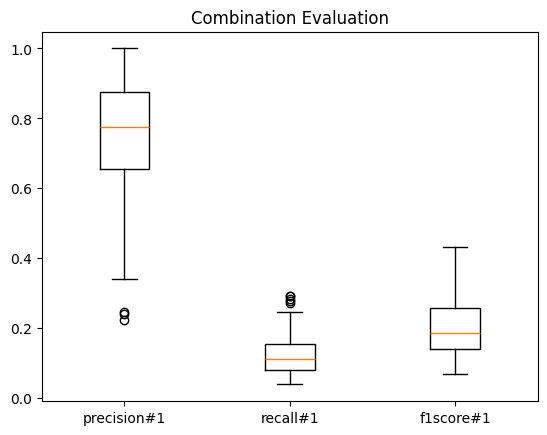

In [12]:
# Visualize
from matplotlib import pyplot as plt
res_path = "result-combination.csv"
df = pd.read_csv(res_path)
average_precision1 = df['precision#1'].mean()
average_recall1 = df['recall#1'].mean()
average_f1score1 = df['f1score#1'].mean()

print("Average Precision#1: ", average_precision1)
print("Average Recall#1: ", average_recall1)
print("Average F1score#1: ", average_f1score1)

# draw box plot
fig, ax = plt.subplots()
ax.set_title('Combination Evaluation')
ax.boxplot([df['precision#1'], df['recall#1'], df['f1score#1']])
ax.set_xticklabels(['precision#1', 'recall#1', 'f1score#1'])
plt.show()

In [13]:
fig.savefig("result-combination.png")

In [6]:
df[['category', 'question', 'answer']].to_csv("manual-evaluation.csv", index=False)

In [30]:
!pip install markdown cairosvg

  Obtaining dependency information for markdown from https://files.pythonhosted.org/packages/fc/b3/0c0c994fe49cd661084f8d5dc06562af53818cc0abefaca35bdc894577c3/Markdown-3.6-py3-none-any.whl.metadata
  Obtaining dependency information for cairosvg from https://files.pythonhosted.org/packages/01/a5/1866b42151f50453f1a0d28fc4c39f5be5f412a2e914f33449c42daafdf1/CairoSVG-2.7.1-py3-none-any.whl.metadata
  Obtaining dependency information for cairocffi from https://files.pythonhosted.org/packages/93/d8/ba13451aa6b745c49536e87b6bf8f629b950e84bd0e8308f7dc6883b67e2/cairocffi-1.7.1-py3-none-any.whl.metadata
  Obtaining dependency information for cssselect2 from https://files.pythonhosted.org/packages/9d/3a/e39436efe51894243ff145a37c4f9a030839b97779ebcc4f13b3ba21c54e/cssselect2-0.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for defusedxml from https://files.pythonhosted.org/packages/07/6c/aa3f2f849e01cb6a001cd8554a88d4c77c5c1a31c95bdf1cf9301e6d9ef4/defusedxml-0.7.1-py2.py3-none-


[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
# Generate Image
# !pip install pillow

import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import textwrap
import markdown
from markdown import markdown
from io import BytesIO
import cairosvg

# Load the CSV file
csv_file = 'manual-evaluation.csv'  # Change this to your CSV file path
data = pd.read_csv(csv_file)
data = data.head(1)

def wrap_text(text, font, max_width):
    lines = []
    words = text.split()
    while words:
        line = ''
        while words and font.getlength(line + words[0]) <= max_width:
            line += (words.pop(0) + ' ')
        lines.append(line)
    return lines

# Function to create an image from text
def create_image(question, answer, output_path, width=800, height=600):
    # Create a blank image with white background
    image = Image.new('RGB', (width, height), 'white')
    draw = ImageDraw.Draw(image)

    # Load a font
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()

    # Define text position and wrap the text if necessary
    margin = 10
    offset = margin

    # Draw question
    question_lines = wrap_text("Q: " + question, font, width - 2 * margin)
    for line in question_lines:
        draw.text((margin, offset), line, fill="black", font=font)
        offset += font.getsize(line)[1] + margin

    # Convert Markdown to HTML, then to SVG, then to PNG
    html_content = markdown("A: " + answer)
    svg_content = f"<svg width='{width - 2 * margin}' height='{height - offset}' xmlns='http://www.w3.org/2000/svg'><foreignObject width='100%' height='100%'><body xmlns='http://www.w3.org/1999/xhtml'>{html_content}</body></foreignObject></svg>"
    png_data = cairosvg.svg2png(bytestring=svg_content.encode('utf-8'))
    png_image = Image.open(BytesIO(png_data))

    # Paste the PNG onto the original image
    image.paste(png_image, (margin, offset))

    # Save the image
    image.save(output_path)

# Iterate through the data and create images
for index, row in data.iterrows():
    question = row['question']  # Adjust these column names to match your CSV
    answer = row['answer']
    output_path = f'output_{index + 1}.png'
    print(question, answer, output_path)
    create_image(question, answer, output_path)
    print(f'Image saved: {output_path}')


OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.so.2'
cannot load library 'libcairo.2.dylib': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.2.dylib'
cannot load library 'libcairo-2.dll': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo-2.dll'

In [40]:
from PIL import ImageFont, ImageDraw, Image
import markdown
import re

def markdown_to_image(text, font_path, font_size, background_color="white", text_color="black", output_path="output.png"):
  """
  Converts Markdown text to an image using Pillow and markdown, handling multiline text.

  Args:
    text: The Markdown text to be converted.
    font_path: Path to the font file for the text.
    font_size: Size of the font.
    background_color: Background color of the image (default: white).
    text_color: Color of the text (default: black).
    output_path: Path to save the generated image (default: output.png).
  """
  # Convert Markdown to plain text (limited HTML support in markdown library)
  text = markdown.markdown(text)

  # Create a new image with desired background color
  width, height = 800, 600 # Adjust width and height as needed
  image = Image.new("RGB", (width, height), background_color)
  draw = ImageDraw.Draw(image)

  # Load the font
  font = ImageFont.truetype(font_path, font_size)

  # Current y position for text lines
  y = 10  # Adjust initial y position

  # Split text into lines and iterate
  for line in re.split(r"\n", text):
    # Get the width of the current line
    line_width = draw.textlength(line.strip(), font=font)

    # Center the line horizontally
    x = (width - line_width) // 2

    # Draw the line on the image
    draw.text((x, y), line.strip(), font=font, fill=text_color)

    # Update y position for the next line
    y += font.size * 1.2  # Adjust line spacing based on font size

  # Save the image
  image.save(output_path)

# Example usage
text = """
  Prosedur pengambilan mata kuliah Tugas Akhir di Fakultas Informatika meliputi:\n1. Masa Persiapan:\n   - Kelompok Keahlian (KK) mengusulkan Topik TA kepada Prodi.\n   - Kelas MK Penulisan Proposal TA mewakili satu bidang peminatan dengan dosen pengampu dan dosen anggota yang menawarkan topik TA.\n\n2. Masa Pra-registrasi:\n   - Fakultas menawarkan topik-topik TA dan calon pembimbing kepada calon mahasiswa.\n   - Calon mahasiswa mendaftar publikasi ilmiah yang diakui Fakultas Informatika.\n   - Calon mahasiswa memilih topik TA dan pembimbing sesuai kuota yang ditetapkan.\n\n3. Tahap Registrasi:\n   - Mahasiswa mendaftar mata kuliah Tugas Akhir sesuai dengan topik dan pembimbing yang telah dipilih.\n   - Mahasiswa menyelesaikan persyaratan administrasi yang diperlukan untuk mengikuti mata kuliah Tugas Akhir.
"""
font_path = "arial.ttf" # Replace with your font path
markdown_to_image(text, font_path, 20)

In [46]:
from PIL import ImageFont, ImageDraw, Image
import markdown  # for basic text processing (optional)
import re

def markdown_to_image(text, font_path, background_color="white", text_color="black", output_path="output.png"):
  """
  Converts Markdown text to an image using Pillow, applying basic styling based on Markdown syntax.

  Args:
    text: The Markdown text to be converted.
    font_path: Path to the font file for the text.
    background_color: Background color of the image (default: white).
    text_color: Color of the text (default: black).
    output_path: Path to save the generated image (default: output.png).
  """
  # Pre-process text using markdown library for basic formatting (optional)
  # You can comment out this line if you don't need basic text processing.
  text = markdown.markdown(text)
  print(text)

  # Split text into lines and create image
  lines = text.splitlines()
  width, height = 800, 600  # Adjust width and height as needed
  image = Image.new("RGB", (width, height), background_color)
  draw = ImageDraw.Draw(image)

  # Load the font
  font = ImageFont.truetype(font_path, 16)  # Adjust initial font size
  current_font_size = font.size
  line_y = 10  # Adjust initial y position

  # Iterate through lines and apply styling based on syntax
  for line in lines:
    # Check for headings (lines starting with #)
    if line.startswith("#"):
      # Adjust font size and style for headings (more #s, bigger font)
      num_hashes = len(re.findall(r"^#+", line))
      font_size = current_font_size * (1.2 ** (num_hashes - 1))  # Increase font size for each #
      font = ImageFont.truetype(font_path, font_size=int(font_size))
      draw.text((10, line_y), line.strip("#"), font=font, fill=text_color)
    else:
      # Check for indentation (likely list items)
      indent_count = len(re.findall(r"^ +", line))  # Count leading spaces
      # Adjust x position based on indentation level
      x_pos = 10 + indent_count * (font.size * 0.6)  # Adjust indent spacing
      draw.text((x_pos, line_y), line.strip(), font=font, fill=text_color)
    # Update y position for the next line
    line_y += font.size * 1.2  # Adjust line spacing based on font size

  # Save the image
  image.save(output_path)

# Example usage
text = """# This is a heading 1
## This is a heading 2

Here is some text with *italics* and **bold** words.

* This is a list item
  * This is a nested list item

Here is another line of text."""
font_path = "arial.ttf" # Replace with your font path
markdown_to_image(text, font_path)

<h1>This is a heading 1</h1>
<h2>This is a heading 2</h2>
<p>Here is some text with <em>italics</em> and <strong>bold</strong> words.</p>
<ul>
<li>This is a list item</li>
<li>This is a nested list item</li>
</ul>
<p>Here is another line of text.</p>


In [1]:
import pandas as pd
df = pd.read_csv("manual-evaluation-results.csv")
df.head()

,Timestamp,Email Address,Nama,1,2,3,4,5,6,7,...,51,52,53,54,55,56,57,58,59,60
0,01/07/2024 9:22:32,dadenurjanah@gmail.com,Dade Nurjanah,5,4,2,1,4,3,5,...,4,4,4,4,4,4,4,4,4,4
1,01/07/2024 14:16:59,gia.septiana@gmail.com,Gia Septiana Wulandari,4,5,2,1,3,3,5,...,4,4,5,5,4,5,4,4,5,3


In [3]:
df.drop(columns=["Timestamp", "Email Address"], inplace=True)

In [40]:
# Remove the 'Nama' column to focus on numeric data
df_numeric = df.drop(columns=['Nama'])

# Calculate the mean score for each question
question_means = df_numeric.mean()

# Sort means to get the top 5 highest and lowest
sorted_means = question_means.sort_values()

# Get the top 5 lowest and highest mean questions
lowest_questions = sorted_means.head(5).to_dict()
highest_questions = sorted_means.tail(5).to_dict()

# Add the mean scores to the DataFrame
df_means = pd.DataFrame([question_means], index=['Mean'])

# Append 'Nama' column to the means DataFrame
df_means['Nama'] = 'Mean'

# Reorder columns to match the original DataFrame
df_means = df_means[['Nama'] + [col for col in df_means.columns if col != 'Nama']]

# Concatenate the original DataFrame with the means DataFrame
df_with_means = pd.concat([df, df_means], ignore_index=True)

# Save to CSV
df_with_means.to_csv('evaluation_with_means.csv', index=False)

# Display the results
print("Top 5 Lowest Mean Questions:", lowest_questions)
print("Top 5 Highest Mean Questions:", highest_questions)

# For demonstration, print the means as well
print("\nMean Scores:")
print(question_means)

Top 5 Lowest Mean Questions: {'4': 1.0, '42': 1.5, '3': 2.0, '43': 2.0, '11': 2.0}
Top 5 Highest Mean Questions: {'18': 5.0, '29': 5.0, '10': 5.0, '7': 5.0, '19': 5.0}

Mean Scores:
1     4.5
2     4.5
3     2.0
4     1.0
5     3.5
6     3.0
7     5.0
8     2.5
9     4.5
10    5.0
11    2.0
12    4.5
13    4.5
14    4.0
15    4.5
16    4.0
17    4.5
18    5.0
19    5.0
20    4.5
21    4.5
22    4.0
23    4.5
24    3.5
25    3.5
26    4.5
27    4.5
28    4.0
29    5.0
30    4.5
31    4.5
32    4.0
33    4.5
34    3.5
35    4.5
36    4.0
37    4.5
38    4.5
39    4.5
40    4.5
41    2.5
42    1.5
43    2.0
44    4.5
45    4.0
46    4.5
47    4.5
48    4.5
49    3.5
50    3.5
51    4.0
52    4.0
53    4.5
54    4.5
55    4.0
56    4.5
57    4.0
58    4.0
59    4.5
60    3.5
dtype: float64


In [88]:
value_counts = {
    4.5: 0.466667,
    4.0: 0.200000,
    3.5: 0.116667,
    5.0: 0.083333,
    2.0: 0.050000,
    2.5: 0.033333,
    1.0: 0.016667,
    3.0: 0.016667,
    1.5: 0.016667
}

# Define thresholds for high and low means
high_threshold = [3.5, 4, 4.5, 5]
mid_threshold = [3]
low_threshold = [1, 1.5, 2, 2.5]

# Calculate total high means
total_high_means = sum(value_counts[mean] for mean in value_counts if mean in high_threshold)

total_mid_means = sum(value_counts[mean] for mean in value_counts if mean in mid_threshold)

# Calculate total low means
total_low_means = sum(value_counts[mean] for mean in value_counts if mean in low_threshold)

# Display results
print("Total High Means (3-5):", total_high_means)
print("Total Mid Means (3):", total_mid_means)
print("Total Low Means (1-2.5):", total_low_means)

Total High Means (3-5): 0.866667
Total Mid Means (3): 0.016667
Total Low Means (1-2.5): 0.116667


In [ ]:
4.5    0.466667
4.0    0.200000
3.5    0.116667
5.0    0.083333

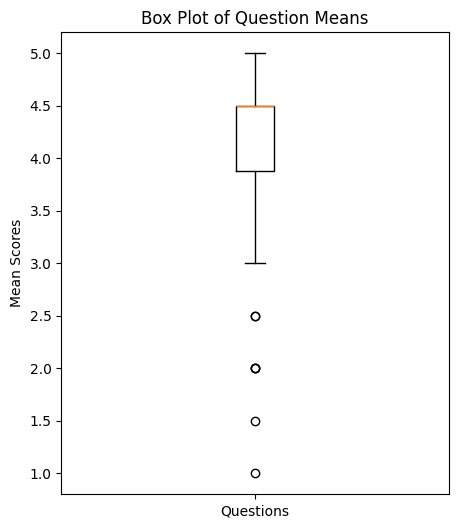

In [55]:
import matplotlib.pyplot as plt

# Remove the 'Nama' column to focus on numeric data
df_numeric = df.drop(columns=['Nama'])

# Calculate the mean score for each question
question_means = df_numeric.mean()

# Create a box plot for the question means
plt.figure(figsize=(5, 6))
plt.boxplot(question_means.values, patch_artist=False, widths=0.1)
plt.xticks([1], ['Questions'])
plt.ylabel('Mean Scores')
plt.title('Box Plot of Question Means')
# plt.grid(True)
plt.show()

In [64]:
res = pd.read_csv("result-combination.csv")
res_numeric = res.drop(columns=['category', 'question', 'answer', 'reference'])
res_means = res_numeric.mean()

In [65]:
res_means

precision#1    0.716069
recall#1       0.128691
f1score#1      0.208287
precision#2    0.387400
recall#2       0.053830
f1score#2      0.090630
bestscore      1.000000
dtype: float64

# BERT Score
https://openreview.net/forum?id=SkeHuCVFDr


In [1]:
!pip install bert_score

^C


  Obtaining dependency information for bert_score from https://files.pythonhosted.org/packages/c6/8c/bc5457de4c004b1a623b31f7bc8d0375fb699b7d67df11879098b4b7b7c8/bert_score-0.3.13-py3-none-any.whl.metadata
  Obtaining dependency information for torch>=1.0.0 from https://files.pythonhosted.org/packages/d3/1d/a257913c89572de61316461db91867f87519146e58132cdeace3d9ffbe1f/torch-2.3.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for transformers>=3.0.0 from https://files.pythonhosted.org/packages/6a/dc/23c26b7b0bce5aaccf2b767db3e9c4f5ae4331bd47688c1f2ef091b23696/transformers-4.42.4-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/43.6 kB ? eta -:--:--
     ---------------------------------------- 43.6/43.6 kB 1.1 MB/s eta 0:00:00
  Obtaining dependency information for mkl<=2021.4.0,>=2021.1.1 from https://files.pythonhosted.org/packages/fe/1c/5f6dbf18e8b73e0a5472466f0ea8d48ce9efae39bd2ff38cebf8dce61259/mkl-2021.4.0-py2.py3-none-win_amd64.wh


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import bert_score

# Example candidate and reference sentences
candidates = ["Prosedur pengambilan mata kuliah Tugas Akhir di Fakultas Informatika meliputi:\n1. Kelompok Keahlian (KK) mengusulkan topik TA kepada Prodi.\n2. Fakultas menawarkan topik TA dan calon pembimbing kepada calon mahasiswa.\n3. Calon mahasiswa mendaftar publikasi ilmiah yang diakui Fakultas Informatika.\n4. Mahasiswa memilih topik TA dan pembimbing sesuai kuota yang ditawarkan.\n5. Mahasiswa mendaftar mata kuliah Tugas Akhir sesuai prosedur yang berlaku.."]
references = ["Topik Tugas Akhir di Fakultas Informatika (FIF) ditetapkan dan dikelola oleh Kelompok  \nKeahlian (KK) FIF. KK akan menawarkan topik TA kepada Prodi Sarjana sesuai dengan  \nkebutuhan  visi keilmuan  dari Prodi  terkait.  Adapun  alur proses  penawaran  topik  TA oleh Prodi  \ndan pengambilan  TA oleh mahasiswa  dapat  dilihat  pada  Tabel  2. \n \nTabel  2. Proses  Penawaran  Topik  Tugas  Akhir.  \n \nNo Waktu  Keterangan  \n1 Masa Persiapan  \nSemester  Kelompok  Keahlian  (KK)  di bawah  Fakultas  Informatika:  \n1. mendiskusikan dan mengusulkan Topik TA kepada Prodi, yang  \ndibagi  menjadi  satu atau beberapa  judul  peminatan  pada KK tersebut,  \n2. satu kelas  MK Penulisan  Proposal TA  mewakili  satu bidang  \npeminatan  dibawah  KK, yang  terdiri  1 dosen  pengampu  MK, dan \nbeberapa  dosen  anggota  yang  menawarkan  topik TA.  \n2 Masa  Pra-registrasi  Fakultas  menawarkan  topik -topik  TA dan calon  pembimbing  beserta  \nkuota  masing -masing  dosen  kepada calon  mahasiswa daftar publikasi ilmiah yang diakui Fakultas Informatika, yaitu Jurnal Internasional  \ndan/atau Prosiding Internasional terindeks Scopus dan/atau Web of Science (WoS),  \nJurnal  Nasional Terindeks  Sinta  1 s/d 4 atau jurnal  internal Fakultas  Informatika.  \nc) HaKI  dalam bentuk  Paten,  Desain  Industri  dan Hak Cipta; atau  \nd) Luaran  lain yang  ditetapkan  oleh Fakultas  Informatika.  \n \n1.1.2.  Tujuan  Tugas  Akhir  \n \nMata  kuliah  (MK)  Tugas  Akhir  diselenggarakan untuk  mencapai tiga  kompetensi  lulusan  atau \nCourse  Learning  Outcome  (CLO),  yaitu:  \n1) Mampu membuat karya tulis ilmiah yang mengkaji atau menerapkan konsep ilmu  \npengetahuan/teknologi bidang informatika dan komputer berdasarkan kaidah, tata cara  \ndan etika  ilmiah;  dan \n2) Mampu  mengkomunikasikan  dan berargumen  secara  lisan  dan tulisan  terkait  \nsolusi/gagasan/desain h asil kajian ilmu pengetahuan/teknologi bidang informatika dan  \nkomputer;  dan 6  KATA  PENGANTAR  \n \nTugas Akhir merupakan salah satu mata kuliah wajib dalam Kurikulum  2020 program sarjana  \ndi Fakultas  Informatika.  Oleh  karena  itu mekanisme  pelaksanaan  Tugas  Akhir  harus  \ndilaksanakan secara terencana, terukur dan terpantau dengan baik. Salah satu substansi  dalam  \nTugas Akhir adalah mengasah, mengukur dan memberikan ruang i novasi serta kreativitas  \ndalam keilmuan bidang informatika dan komputer. Hal inilah yang menjadi landasan kami  \nuntuk  semakin memperkuat budaya  penelitian  di Fakultas  Informatika.  \n \nSeiring implementasi Kurikulum 2020, dan penyesuaian kurikulum 2020 yang dilakukan di  \n2022, di Telkom University serta hasil pencapaian tingkat  kelulusan dalam Tugas Akhir yang  \nmasih perlu terus ditingkatkan menjadi salah satu pertimbangan dalam revisi panduan Tugas  \nAkhir  pada  program  sarjana  di Fakultas  Informatika.  Selain  itu, skema  pengganti  sidang  Tugas 5  KATA  PENGANTAR  \n \nTugas Akhir merupakan salah satu mata kuliah wajib dalam Kurikulum 2020 program sarjana  \ndi Fakultas  Informatika.  Oleh  karena  itu mekanisme  pelaksanaan  Tugas  Akhir  harus  \ndilaksanakan secara terencana, terukur dan terpantau dengan baik. Salah satu substansi dalam  \nTugas Akhir adalah mengasah, mengukur dan memberikan ruang inovasi serta kreativitas  \ndalam keilmuan bidang informatika dan komputer. Hal inilah yang menjadi landasan kami  \nuntuk  semakin memperkuat budaya  penelitian  di Fakultas  Informatika.  \n \nSeiring implementasi Kurikulum 2020, dan penyesuaian kurikulum 2020 yang dilakukan di  \n2022, di Telkom University serta hasil pencapaian tingkat kelulusan dalam Tugas Akhir yang  \nmasih perlu terus ditingkatkan menjadi salah satu pertimbangan dalam revisi panduan Tugas  \nAkhir  pada  program  sarjana  di Fakultas  Informatika.  Selain  itu, skema  pengganti  sidang  Tugas"]

P, R, F1 = bert_score.score(candidates, references, lang="en", verbose=True)

# Print the scores
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall: {R.mean().item():.4f}")
print(f"F1 Score: {F1.mean().item():.4f}")

In [3]:
import pandas as pd
df_comb = pd.read_csv("result-bert-score-combination.csv")
df_docs = pd.read_csv("result-bert-score-docs.csv")
df_interview = pd.read_csv("result-bert-score-interview.csv")

In [5]:
print(df_docs["prec"].mean(), df_docs["rec"].mean(), df_docs["f1"].mean())
print(df_interview["prec"].mean(), df_interview["rec"].mean(), df_interview["f1"].mean())
print(df_comb["prec"].mean(), df_comb["rec"].mean(), df_comb["f1"].mean())

0.7429457247257233 0.5830144733190536 0.6522805362939834
0.7563175141811371 0.597547996044159 0.6673226952552795
0.7492951367582593 0.5870493067162378 0.6573993248598916
